# Algorithme k-means et k-medoids 
## Sur des données de test  
----

# To do :  
- ~~Algorithme KMeans~~
- ~~Ajouter distance L1 et distance cosinus~~
- Comparer KMeans avec le code de l'algorithme de sklearn ==> difficile à comprendre
- Faire des clusters avec des gaussiennes pour test
- ~~Tester cos avec des nuages de points alignés de la forme :  ~~  
- ~~Tester L1 sur un quadrillage (cos est bien sur les deux lignes de points)~~
- ~~Algorithme de k-medoids~~
- Complexité des algorithmes  
==> KMeans : O(tkn) - KMedoids : O(?)

  
- ~~Retravailler le choix du min pour cos (0) ==> on prend la valeur absolue puis le min~~
- Retravailler la moyenne dans update_centroids qui n'est pas bonne pour cos et l1  
==> pour L1 c'est la même que pour euc, ou prendre la medianne plutot que la moyenne ?  
==> Pour cos, on parle de normaliser les vecteurs, pourquoi et à quel moment ? Que faire ensuite ?
----

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.spatial import Voronoi, voronoi_plot_2d
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

/home/guillaume/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Classes

In [2]:
class Point():
    
    def __init__(self, coords, color='black'):
        self.coords = coords
        self.x = self.coords[0]
        self.y = self.coords[1]
        self.color = color

In [154]:
class KMeans:
    
    def __init__(self, n_clusters=2, n_iter=100, dist='euc'):
        """
        n_clusters : int
            Nombre de clusters à former. 2 par défaut.
        
        n_iter : int
            Nombre d'itérations. 10 par défaut.
        
        dist : string
            Nom de la distance à utiliser. Distance euclidienne par défaut.
            - 'euc' : distance euclidienne
            - 'cos' : "distance" cosinus
            - 'l1'  : distance L1, ou de Manhattan
        """
        self.K = n_clusters
        self.n_iter = n_iter
        self.dist = dist
        
    def fit(self, X, drawing=False):
        """
        On effectue un nombre d'itérations fixe défini par self.n_iter
        """
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        
        # On choisi K points aléatoirement pour être les centroides
        self.centroids = X[np.random.choice(len(X), self.K, replace=False)]
        self.initial_centroids = self.centroids
        self.prev_label,  self.labels = None, np.zeros(len(X))
        # On effectue n_iter itérations
        for i in range(1,self.n_iter+1):
            self.prev_label = self.labels
            # On calcule la distance de chaque point aux centroids
            # et on affecte un point à la classe ayant le centroide le plus proche
            self.labels = self.predict_labels(X, self.centroids, self.dist)
            # On change le centroide de chaque classe en prenant la moyenne des points de cette classe
            self.update_centroid(X)
            
            if i % 10 == 0: #On plot toutes les 10 itérations
                self.draw_graph(X, i=i, show=drawing) 
        return self
        
    def predict_labels(self, X, centroids, dist='euc'):
        if dist in ['euc', 'l1']:
            return self.distance(X, centroids, dist).argmin(axis=1)
        elif dist=='cos':
            return abs(self.distance(X, centroids, dist)).argmin(axis=1)
    
    def distance(self, X, centroids, dist='euc'):
        map = {'euc':'euclidean', 'cos':'cosine', 'l1':'cityblock'}
        return sp.spatial.distance.cdist(X, centroids, metric=map[dist])
    
    def update_centroid(self, X):
        self.centroids = np.array([np.mean(X[self.labels == k], axis=0)  for k in range(self.K)])
        # On pourrait utiliser np.median au lieu de np.mean pour L1
        
    def draw_graph(self, X, i=0, show=True):
        plt.scatter(X[:, 0], X[:, 1], c=self.labels, s=50, cmap='viridis')
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c='black', s=200, alpha=0.5)
        plt.xlabel('x'); plt.ylabel('y'); plt.title(f'Iteration n°{i}')
        self.graph = plt.gcf()
        if show: plt.show()
        else: plt.close(self.graph)


In [4]:
class KMedoids:
    
    def __init__(self, n_clusters=2, n_iter=100, dist='euc'):
        """
        n_clusters : int
            Nombre de clusters à former. 2 par défaut.
        
        n_iter : int
            Nombre d'itérations. 10 par défaut.
        
        dist : string
            Nom de la distance à utiliser. Distance euclidienne par défaut.
            - 'euc' : distance euclidienne
            - 'cos' : "distance" cosinus
            - 'l1'  : distance L1, ou de Manhattan
        """
        self.K = n_clusters
        self.n_iter = n_iter
        self.dist = dist
        
    def fit(self, X, drawing=False):
        """
        On effectue un nombre d'itérations fixe défini par self.n_iter
        """
        if not isinstance(X, np.ndarray):
            X = np.array(X)
            
        self.centroids = X[np.random.choice(len(X), self.K, replace=False)]
        self.initial_centroids = self.centroids
        self.prev_label,  self.labels = None, np.zeros(len(X))
        for i in range(1,self.n_iter+1):
            self.prev_label = self.labels
            self.labels = self.predict_labels(X, self.centroids, self.dist)
            self.update_centroid(X, self.dist)
            
            if i % 10 == 0: #On plot toutes les 10 itérations
                self.draw_graph(X, i=i, show=drawing) 
        return self
        
    def predict_labels(self, X, centroids, dist='euc'):
        if dist in ['euc', 'l1']:
            return self.distance(X, centroids, dist).argmin(axis=1)
        elif dist=='cos':
            return abs(self.distance(X, centroids, dist)).argmin(axis=1)
    
    def distance(self, X, centroids, dist='euc'):
        map = {'euc':'euclidean', 'cos':'cosine', 'l1':'cityblock'}
        return sp.spatial.distance.cdist(X, centroids, metric=map[dist])
    
    def update_centroid(self, X, dist='euc'):
        self.centroids = np.array([np.mean(X[self.labels == k], axis=0)  for k in range(self.K)])
        distances = self.distance(X, self.centroids, dist=dist)
        self.centroids = X[distances.argmin(axis=0)]
        
    def draw_graph(self, X, i=0, show=True):
        plt.scatter(X[:, 0], X[:, 1], c=self.labels, s=50, cmap='viridis')
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c='black', s=200, alpha=0.5)
        plt.xlabel('x'); plt.ylabel('y'); plt.title(f'Iteration n°{i}')
        self.graph = plt.gcf()
        if show: plt.show()
        else: plt.close(self.graph)

        

----
## Test avec points 2D

In [5]:
p1 = Point([1.5, 2], 'b')
p2 = Point([1, 1], 'b')
p3 = Point([3, 2.5], 'b')
p4 = Point([3.1, 2], 'b')
p5 = Point([2.5, 2], 'b')
p6 = Point([2.9, 3], 'b')


p7 = Point([8, 5], 'r')
p8 = Point([9, 5.5], 'r')
p9 = Point([7.5, 6], 'r')
p10 = Point([7, 6.2], 'r')
p11 = Point([8.5, 4.8], 'r')
p12 =Point([7, 6], 'r')

p13 = Point([1, 7], 'g')
p14 = Point([2.5, 7.9], 'g')
p15 = Point([3, 8], 'g')
p16 = Point([2, 9.8], 'g')
p17 = Point([1.5, 9.5], 'g')
p18 = Point([2.2, 8.8], 'g')

L = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, p16, p17, p18]

X = [p.x for p in L]
Y = [p.y for p in L]
colors = [p.color for p in L]
df = pd.DataFrame({'X':X, 'Y':Y, 'colors':colors})

df_X = df.loc[:,['X','Y']]

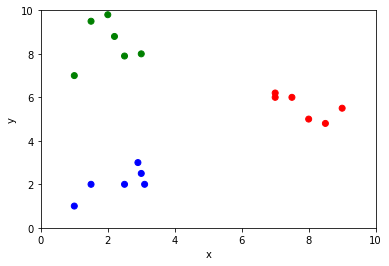

In [6]:
plt.scatter(df['X'], df['Y'], c=colors)

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

----

In [21]:
kmeans = KMeans(n_clusters=3, n_iter=100, dist='euc')
kmeans.fit(df_X, drawing=False)
kmeans.labels

array([0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1])

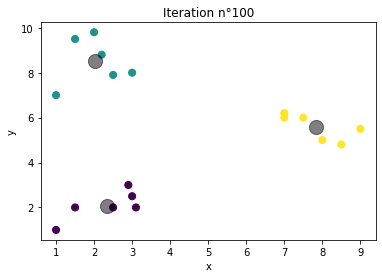

In [22]:
kmeans.graph

In [31]:
kmed = KMedoids(n_clusters=3, n_iter=100, dist='euc')
kmed.fit(df_X, drawing=False)
kmed.labels

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])

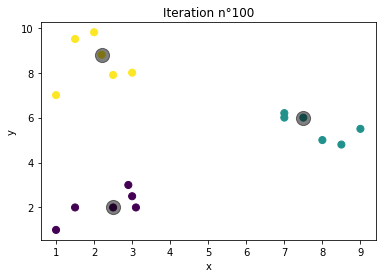

In [32]:
kmed.graph

----

## Test cas particulier - distance cos

In [33]:
p1 = Point([1, 2], 'b')
p2 = Point([3, 2], 'b')
p3 = Point([5, 2], 'b')
p4 = Point([7, 2], 'b')
p5 = Point([9, 2], 'b')

p6 = Point([1, 6], 'g')
p7 = Point([3, 6], 'g')
p8 = Point([5, 6], 'g')
p9 = Point([7, 6], 'g')
p10 = Point([9, 6], 'g')


L = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10]

X = [p.x for p in L]
Y = [p.y for p in L]
colors = [p.color for p in L]
df = pd.DataFrame({'X':X, 'Y':Y, 'colors':colors})

df_X = df.loc[:,['X','Y']]

df;

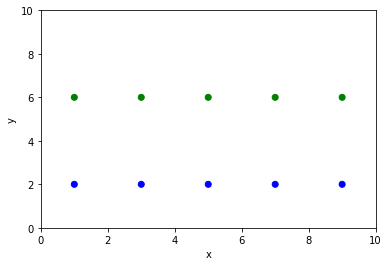

In [34]:
plt.scatter(df['X'], df['Y'], c=colors)

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

In [85]:
kmeans = KMeans(n_clusters=2, n_iter=500, dist='cos')
kmeans.fit(df_X, drawing=False)
kmeans.labels

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 1])

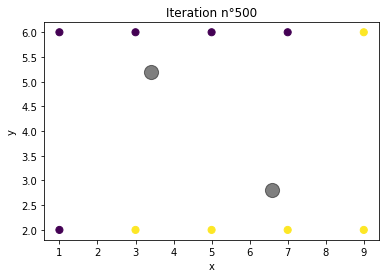

In [86]:
kmeans.graph

In [71]:
kmed = KMedoids(n_clusters=2, n_iter=100, dist='l1')
kmed.fit(df_X, drawing=False)
kmed.labels

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

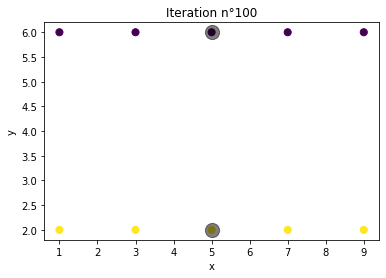

In [72]:
kmed.graph

----

## Test cas particulier - distance L1

In [200]:
p1 = Point([1, 2])
p2 = Point([3, 2])
p3 = Point([5, 2])
p4 = Point([7, 2])
p5 = Point([9, 2])

p6 = Point([1, 5])
p7 = Point([3, 5])
p8 = Point([5, 5])
p9 = Point([7, 5])
p10 = Point([9, 5])

p11 = Point([1, 8])
p12 = Point([3, 8])
p13 = Point([5, 8])
p14 = Point([7, 8])
p15 = Point([9, 8])

p16 = Point([1, 11])
p17 = Point([3, 11])
p18 = Point([5, 11])
p19 = Point([7, 11])
p20 = Point([9, 11])


L = [p4, p5, p6, p7, p9, p10, p11, p12, p14, p15, p16, p17]

X = [p.x for p in L]
Y = [p.y for p in L]
colors = [p.color for p in L]
df = pd.DataFrame({'X':X, 'Y':Y, 'colors':colors})

df_X = df.loc[:,['X','Y']]

df;

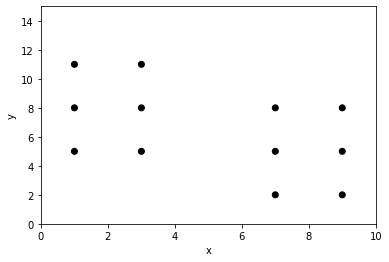

In [201]:
plt.scatter(df['X'], df['Y'], c=colors)

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 10)
plt.ylim(0, 15)
plt.show()

In [208]:
kmeans = KMeans(n_clusters=2, n_iter=500, dist='euc')
kmeans.fit(df_X, drawing=False)
kmeans.labels

array([1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0])

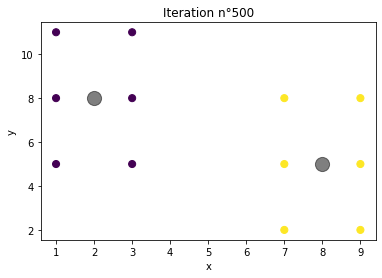

In [209]:
kmeans.graph

In [127]:
kmed = KMedoids(n_clusters=2, n_iter=100, dist='euc')
kmed.fit(df_X, drawing=False)
kmed.labels

array([1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0])

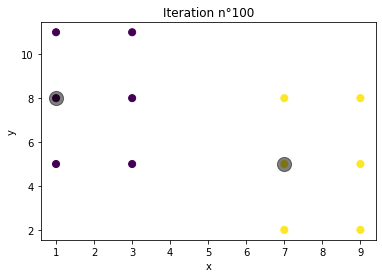

In [128]:
kmed.graph

----

## Test nuage de points gaussien

### sigma_1 ~ sigma_2

Text(0, 0.5, '$x_2$')

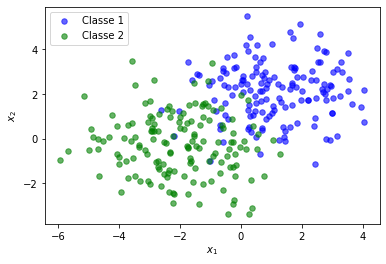

In [129]:
import scipy.stats as stats

c1 = stats.multivariate_normal(mean=[1.,2], cov=2)
c2 = stats.multivariate_normal(mean=[-2,-0.5], cov=2)

c1rvs = c1.rvs(size=150)  #composantes dans la classe 1
c2rvs = c2.rvs(size=150)

data = np.concatenate((c1rvs, c2rvs), axis=0)

x1_1 = c1rvs[:, 0]  #x1 dans la classe 1
x2_1 = c1rvs[:, 1]  #x2 dans la classe 1
x1_2 = c2rvs[:, 0]  #x1 dans la classe 2
x2_2 = c2rvs[:, 1]  #x2 dans la classe 2

# Graph
plt.scatter(x1_1, x2_1, marker='o', s=30, color='blue', alpha=0.6, label='Classe 1')
plt.scatter(x1_2, x2_2, s=30, color='green', alpha=0.6, label='Classe 2')
plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

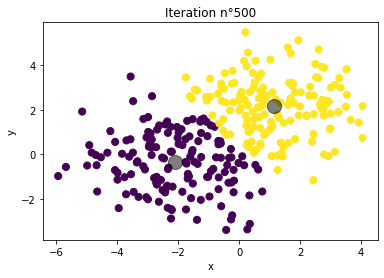

In [138]:
kmeans = KMeans(n_clusters=2, n_iter=500, dist='euc')
kmeans.fit(data, drawing=False)
kmeans.graph

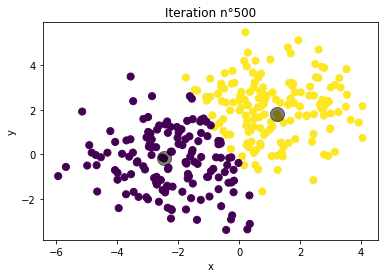

In [133]:
kmed = KMedoids(n_clusters=2, n_iter=500, dist='euc')
kmed.fit(data, drawing=False)
kmed.graph

----

### sigma_1 << sigma_2

Text(0, 0.5, '$x_2$')

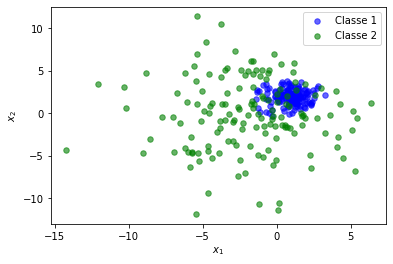

In [139]:
import scipy.stats as stats

c1 = stats.multivariate_normal(mean=[1.,2], cov=1)
c2 = stats.multivariate_normal(mean=[-2,-0.5], cov=15)

c1rvs = c1.rvs(size=150)  #composantes dans la classe 1
c2rvs = c2.rvs(size=150)

data = np.concatenate((c1rvs, c2rvs), axis=0)

x1_1 = c1rvs[:, 0]  #x1 dans la classe 1
x2_1 = c1rvs[:, 1]  #x2 dans la classe 1
x1_2 = c2rvs[:, 0]  #x1 dans la classe 2
x2_2 = c2rvs[:, 1]  #x2 dans la classe 2

# Graph
plt.scatter(x1_1, x2_1, marker='o', s=30, color='blue', alpha=0.6, label='Classe 1')
plt.scatter(x1_2, x2_2, s=30, color='green', alpha=0.6, label='Classe 2')
plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

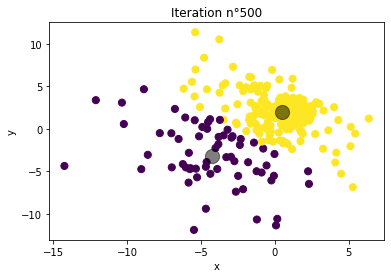

In [140]:
kmeans = KMeans(n_clusters=2, n_iter=500, dist='euc')
kmeans.fit(data, drawing=False)
kmeans.graph

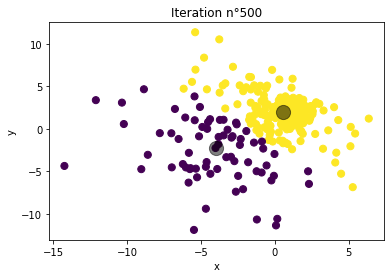

In [141]:
kmed = KMedoids(n_clusters=2, n_iter=500, dist='euc')
kmed.fit(data, drawing=False)
kmed.graph

----

## Test avec scikit-learn

In [153]:
import random as rd
from sklearn.cluster import KMeans as KMeans_sklearn

           x         y
0   8.495969  5.695514
1   2.418479  1.655845
2   2.693669  8.424773
3   5.841716  3.246908
4   6.463766  2.222958
5   1.591494  8.181870
6   0.879650  4.495911
7   1.618278  2.423169
8   8.857958  5.823412
9   8.023874  9.013370
10  4.581192  3.967147
11  3.535224  1.549936
12  0.470915  9.841330
13  7.407005  5.593952
14  9.990298  1.836293
15  1.760579  2.094013
16  9.991767  7.139180
17  4.493228  7.896704
18  7.298474  0.153847
19  7.219738  5.246894


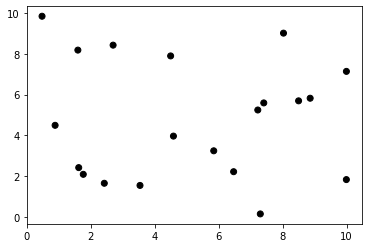

In [149]:
L = [] #liste de points
X = []
Y = []
colors = []
for i in range(20): 
    p = Point([rd.uniform(0,10),rd.uniform(0,10)])
    L.append(p)
    X.append(p.x)
    Y.append(p.y)
    colors.append(p.color)

#création du dataframe sur lequel on va travailler 
df = pd.DataFrame({'x': X, 'y': Y})
print(df)

#création du nuages de points 
plt.scatter(X,Y,c=colors)
plt.show()

Ici, nous allons tester l'implémentation de KMeans faite dans scikit-learn  
  
Pour avoir une information sur le nombre de clusters à former, nous allons utiliser la méthode Elbow. Cela consiste à représenter l'évolution des inerties intraclasse en fonction du nombre de clusters. On choisi alors le nombre de clusters situé au niveau du "coude", le point d'inflexion du graphe.

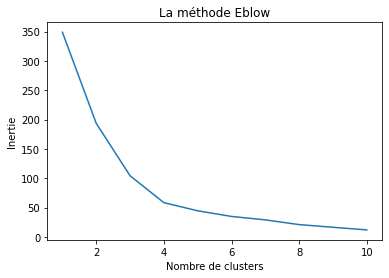

In [150]:
#on suppose que le nombre de clusters n'est pas connu 
tab = []
for i in range(1,11):#on va chercher quel nombre de clusters est optimal 
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df)
    tab.append(kmeans.inertia_)#liste contenant l'inertie intraclasse selon le nombre de clusters
plt.plot(range(1,11),tab)
plt.title("La méthode Eblow")
plt.ylabel("Inertie")
plt.xlabel("Nombre de clusters")
plt.show()

On choisi donc K=4 clusters

Labels : [0 1 2 3 3 2 1 1 0 0 1 1 2 0 3 1 0 2 3 0]
Inertie : 58.51195436463284


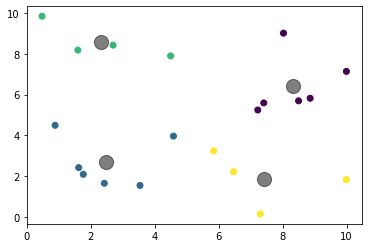

In [190]:
K = 4
kmeans = KMeans_sklearn(n_clusters=K)
kmeans.fit(df)

predictions = kmeans.predict(df)
print("Labels :", predictions)

inertie = kmeans.inertia_
print("Inertie :", inertie)

plt.scatter(X,Y,c=kmeans.predict(df)) #les différents clusters selon les 
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='black', s=200, alpha=0.5)
plt.show()

Utilisons maintenant notre propre modèle KMeans :

[0 1 2 3 3 2 1 1 0 0 3 1 2 0 3 1 0 2 3 0]


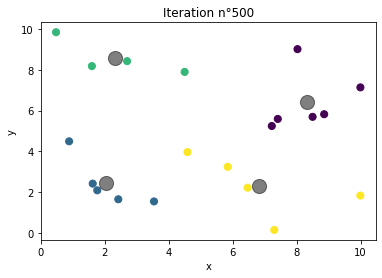

In [189]:
modele = KMeans(n_clusters=4, n_iter=500, dist='euc')
modele.fit(df, drawing=False)

preds = modele.labels
print(preds)
modele.graph

Comparons notre modèle à la version de sklearn

([<matplotlib.patches.Wedge at 0x7fd76846ec90>,
 [Text(-1.086457168210212, 0.17207795223283895, 'identiques'),
  Text(1.0864571621685486, -0.17207799037838706, 'différents')])

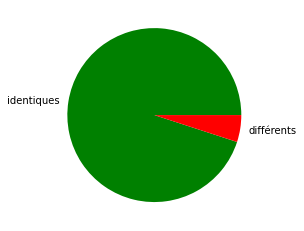

In [199]:
l = 0
for i in range(len(preds)):
    if predictions[i]==preds[i]:
        l+=1
wins = l/len(preds)
plt.pie([wins, 1-wins],labels=['identiques','différents'],colors=['g','r'])

Notre modèle donne un résultat très proche du podèle de sklearn : seulement un point sur 20 est classé différemment sur cet exemple !